<a href="https://colab.research.google.com/github/XiaxiaXu/Predict-Machine-Failure-Using-Sensor-Data/blob/main/CaseStudy_Sensors_ExploratoryAnalysis_BuildRawModels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Case study: Using sensor data to predict the machine failure in advance 
In this case study, I was tasked to help a water supply company to predict the machine failure in advacne. This notebook includes exploratory data analysis of the sensor data, as well as raw models to predict the machine failure in advance. The final version of building the model can be found from [CaseStudy_Sensors_FinalModel.ipynb](https://colab.research.google.com/drive/10qhvQl4sPsCOy29hVh0XAWVQGMX5dFFs). 

Cheers!

Xiaxia, 2021.10.17

---



<h1>Table of contents</h1>

<div class="alert alert-block alert-info" style="margin-top: 20px">
    <ol>
        <li><a>Introduction</a></li>
        <li><a>Import the libraries and get the Data</a></li>
        <li><a>Exploratory analysis</a></li>
        <li><a>Data preparation</a></li>
        <li><a>LSTM Modeling</a></li>
        <li><a>Conclusions</a></li>
        <li><a>References</a></li>
    </ol>
</div>


# 1. Introduction

## 1.1 Aim
* Extract useful insights from the sensor data of one machine;
* Predict the machine failure in advance;

## 1.2 Dataset
* a column of Timestamp data;
* 51 columns of sensor data;
* a column of machine status data;

## 1.3 Overview of this notebook
* First, I explored the data set to get an overview of the data set;
* Second, I analyzed the relationship between sensor data and machine status, so I am sure that sensor data can be used to predict machine failures in advance. 
* Third, I prepared data for the LSTM model.
* Forth, I trained and evaluated the LSTM model. 

# 2. Import the libraries and get the Data

In [ ]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# load the data
df=pd.read_csv('/content/drive/MyDrive/CaseStudy_SensorData/pump_sensor.csv',index_col='timestamp',parse_dates=True)

# 3. Exploratory analysis
## 3.1 Let's first take a look at some basic information, such as headers, column names, data types, null values, and so on.

In [ ]:
# check the head of the data
df.head()

,Unnamed: 0,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,sensor_10,sensor_11,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,sensor_22,sensor_23,sensor_24,sensor_25,sensor_26,sensor_27,sensor_28,sensor_29,sensor_30,sensor_31,sensor_32,sensor_33,sensor_34,sensor_35,sensor_36,sensor_37,sensor_38,sensor_39,sensor_40,sensor_41,sensor_42,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,machine_status
timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-04-01 00:00:00,0,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,15.05353,37.22740,47.52422,31.11716,1.681353,419.5747,NaN,461.8781,466.3284,2.565284,665.3993,398.9862,880.0001,498.8926,975.9409,627.6740,741.7151,848.0708,429.0377,785.1935,684.9443,594.4445,682.8125,680.4416,433.7037,171.9375,341.9039,195.0655,90.32386,40.36458,31.51042,70.57291,30.98958,31.770832,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
2018-04-01 00:01:00,1,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,15.05353,37.22740,47.52422,31.11716,1.681353,419.5747,NaN,461.8781,466.3284,2.565284,665.3993,398.9862,880.0001,498.8926,975.9409,627.6740,741.7151,848.0708,429.0377,785.1935,684.9443,594.4445,682.8125,680.4416,433.7037,171.9375,341.9039,195.0655,90.32386,40.36458,31.51042,70.57291,30.98958,31.770832,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
2018-04-01 00:02:00,2,2.444734,47.35243,53.2118,46.397570,638.8889,73.54598,13.32465,16.03733,15.61777,15.01013,37.86777,48.17723,32.08894,1.708474,420.8480,NaN,462.7798,459.6364,2.500062,666.2234,399.9418,880.4237,501.3617,982.7342,631.1326,740.8031,849.8997,454.2390,778.5734,715.6266,661.5740,721.8750,694.7721,441.2635,169.9820,343.1955,200.9694,93.90508,41.40625,31.25000,69.53125,30.46875,31.770830,41.66666,39.351852,65.39352,51.21528,38.194443,155.9606,67.12963,241.3194,203.7037,NORMAL
2018-04-01 00:03:00,3,2.460474,47.09201,53.1684,46.397568,628.1250,76.98898,13.31742,16.24711,15.69734,15.08247,38.57977,48.65607,31.67221,1.579427,420.7494,NaN,462.8980,460.8858,2.509521,666.0114,399.1046,878.8917,499.0430,977.7520,625.4076,739.2722,847.7579,474.8731,779.5091,690.4011,686.1111,754.6875,683.3831,446.2493,166.4987,343.9586,193.1689,101.04060,41.92708,31.51042,72.13541,30.46875,31.510420,40.88541,39.062500,64.81481,51.21528,38.194440,155.9606,66.84028,240.4514,203.1250,NORMAL
2018-04-01 00:04:00,4,2.445718,47.13541,53.2118,46.397568,636.4583,76.58897,13.35359,16.21094,15.69734,15.08247,39.48939,49.06298,31.95202,1.683831,419.8926,NaN,461.4906,468.2206,2.604785,663.2111,400.5426,882.5874,498.5383,979.5755,627.1830,737.6033,846.9182,408.8159,785.2307,704.6937,631.4814,766.1458,702.4431,433.9081,164.7498,339.9630,193.8770,101.70380,42.70833,31.51042,76.82291,30.98958,31.510420,41.40625,38.773150,65.10416,51.79398,38.773150,158.2755,66.55093,242.1875,201.3889,NORMAL


Quick observation: 
* 'Unnamed: 0' has no information, remove it.
* Sensors have very different scales, keep in mind that we may need to standardize the data.

In [ ]:
# remove unuseful coloumn
df.drop('Unnamed: 0', axis=1, inplace=True)

In [ ]:
# shape
df.shape

(220320, 53)

Quick observation: 53 columns with 220320 recordings

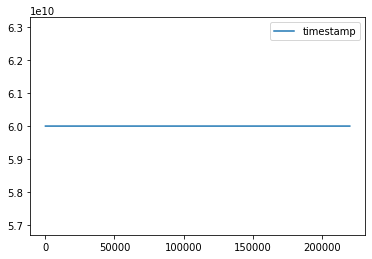

In [ ]:
# Let's check whether the time stamps continues or not
timestep=df.index
pd.DataFrame(timestep).diff().plot(); # Good that the time step is equally distributed.

In [ ]:
# check columns
df.columns

Index(['sensor_00', 'sensor_01', 'sensor_02', 'sensor_03', 'sensor_04',
       'sensor_05', 'sensor_06', 'sensor_07', 'sensor_08', 'sensor_09',
       'sensor_10', 'sensor_11', 'sensor_12', 'sensor_13', 'sensor_14',
       'sensor_15', 'sensor_16', 'sensor_17', 'sensor_18', 'sensor_19',
       'sensor_20', 'sensor_21', 'sensor_22', 'sensor_23', 'sensor_24',
       'sensor_25', 'sensor_26', 'sensor_27', 'sensor_28', 'sensor_29',
       'sensor_30', 'sensor_31', 'sensor_32', 'sensor_33', 'sensor_34',
       'sensor_35', 'sensor_36', 'sensor_37', 'sensor_38', 'sensor_39',
       'sensor_40', 'sensor_41', 'sensor_42', 'sensor_43', 'sensor_44',
       'sensor_45', 'sensor_46', 'sensor_47', 'sensor_48', 'sensor_49',
       'sensor_50', 'sensor_51', 'machine_status'],
      dtype='object')

In [ ]:
# data type for each column
df.dtypes

sensor_00         float64
sensor_01         float64
sensor_02         float64
sensor_03         float64
sensor_04         float64
sensor_05         float64
sensor_06         float64
sensor_07         float64
sensor_08         float64
sensor_09         float64
sensor_10         float64
sensor_11         float64
sensor_12         float64
sensor_13         float64
sensor_14         float64
sensor_15         float64
sensor_16         float64
sensor_17         float64
sensor_18         float64
sensor_19         float64
sensor_20         float64
sensor_21         float64
sensor_22         float64
sensor_23         float64
sensor_24         float64
sensor_25         float64
sensor_26         float64
sensor_27         float64
sensor_28         float64
sensor_29         float64
sensor_30         float64
sensor_31         float64
sensor_32         float64
sensor_33         float64
sensor_34         float64
sensor_35         float64
sensor_36         float64
sensor_37         float64
sensor_38   

In [ ]:
# The number of null value for each column
100*df.isna().sum()/df.shape[0]

sensor_00           4.633261
sensor_01           0.167484
sensor_02           0.008624
sensor_03           0.008624
sensor_04           0.008624
sensor_05           0.008624
sensor_06           2.177741
sensor_07           2.474129
sensor_08           2.317992
sensor_09           2.085603
sensor_10           0.008624
sensor_11           0.008624
sensor_12           0.008624
sensor_13           0.008624
sensor_14           0.009532
sensor_15         100.000000
sensor_16           0.014070
sensor_17           0.020879
sensor_18           0.020879
sensor_19           0.007262
sensor_20           0.007262
sensor_21           0.007262
sensor_22           0.018609
sensor_23           0.007262
sensor_24           0.007262
sensor_25           0.016340
sensor_26           0.009078
sensor_27           0.007262
sensor_28           0.007262
sensor_29           0.032680
sensor_30           0.118464
sensor_31           0.007262
sensor_32           0.030864
sensor_33           0.007262
sensor_34     

Quick observations:
* Sensor_15 has no data, remove it.
* sensor_50 has fairly high percentage of missing values.

In [ ]:
df.drop(['sensor_15'],axis=1,inplace=True)

## 3.2 machine_status
Predicting machine failure in advance is my goal. Therefore, I will first dive deeper into the machine_status column.

### 3.2.1 How many states the machine has and how many time points for each state?

In [ ]:
# the unique values of the target column
df['machine_status'].unique() # there are 3 machine states

array(['NORMAL', 'BROKEN', 'RECOVERING'], dtype=object)

In [ ]:
# how many cases for each state
print('NORMAL:',len(df[df['machine_status']=='NORMAL']))
print('BROKEN:',len(df[df['machine_status']=='BROKEN']))
print('RECOVERING:',len(df[df['machine_status']=='RECOVERING']))

NORMAL: 205836
BROKEN: 7
RECOVERING: 14477


In [ ]:
# map the states to numbers
df.replace({'BROKEN': 1, 'NORMAL': 0,'RECOVERING':0.5}, inplace=True)

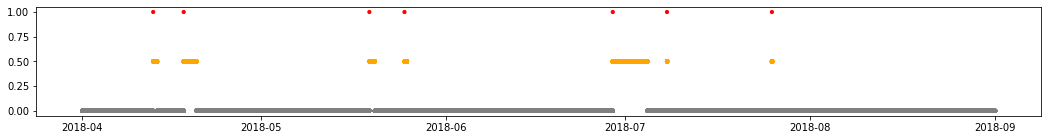

In [ ]:
# visualize the status of the machine
plt.figure(figsize=(18,2))
plt.scatter(df.index, df['machine_status'], s=10, c=df['machine_status'],cmap=matplotlib.colors.ListedColormap(['grey', "orange",'red']));

<Figure size 432x288 with 0 Axes>

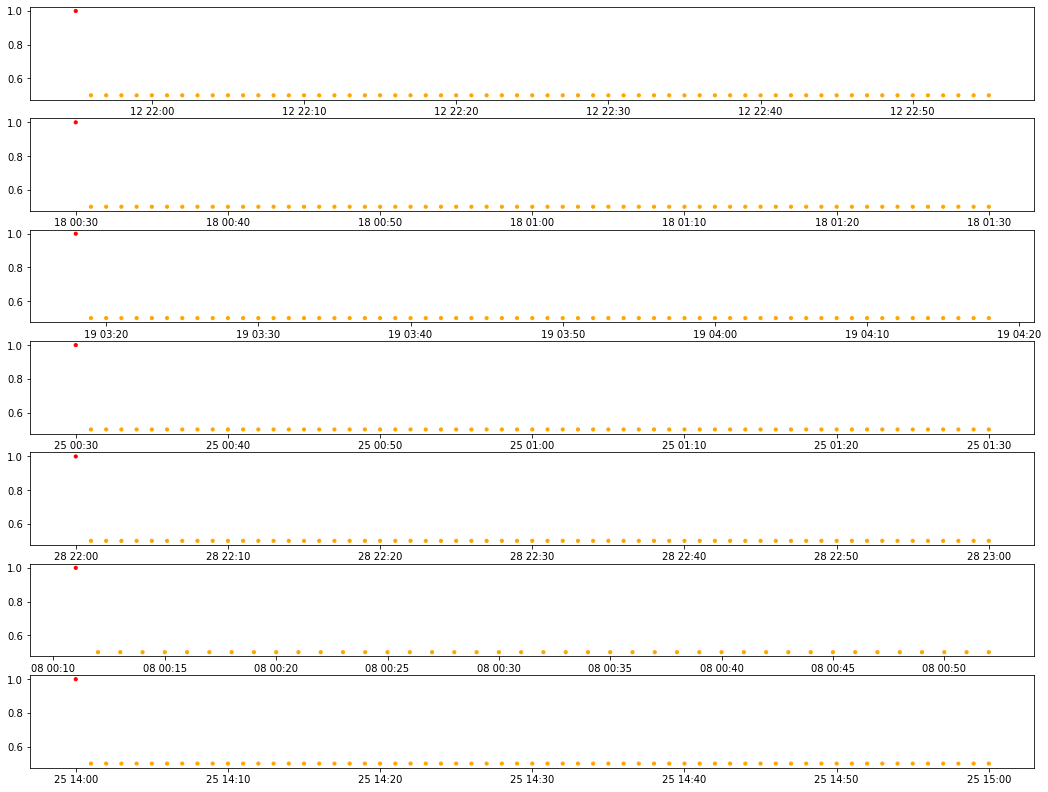

In [ ]:
# broke status vs. recovering status
Failure_times=df[df['machine_status']==1].index
plt.figure()
plt.subplots(figsize=(18,14),nrows=7,ncols=1)
for i,failure_time in enumerate(Failure_times):
  plt.subplot(7,1,i+1)
  start_time=failure_time-pd.Timedelta(seconds=60*10) # 10 mins before the failure time
  stop=failure_time+pd.Timedelta(seconds=60*60) # 30 mins after the failure time
  df_failure_recovering=df[df['machine_status']!=0].loc[start_time:stop]
  plt.scatter(df_failure_recovering.index, df_failure_recovering['machine_status'], s=10, c=df_failure_recovering['machine_status'],cmap=matplotlib.colors.ListedColormap([ "orange",'red']));

Obervations:
* Every time the machine fails, the recovery will start immediately. 
* The machine status: normal-fail-recovery-normal......

In [ ]:
# How long is the recovery time after each failure?
RecoverTimeDiff=df[df['machine_status']==0.5].index.to_series().diff().dt.seconds.div(60)
RecoverDuration=RecoverTimeDiff[RecoverTimeDiff==1].sum()/7/60

# Plot the recovery time after each failure

print(f'Once broke down, the machine needs about {RecoverDuration:.4f}hs to recover!')

Once broke down, the machine needs about 34.4524hs to recover!


In [ ]:
# time period
print(df.index.to_list()[0])
print(df.index.to_list()[-1])

2018-04-01 00:00:00
2018-08-31 23:59:00


Observations:
* In 5 months (2018.04-2018.08), the machine broke down for 7 times!
* The average recovery time after machine failure is 34.45h!

Conclusions:
* It is very important to predict the machine failure in advance!

Thinking:
* Super unbalaced data, normal classification methods will not work.
* For time series, SMOTE (Synthetic Minority Oversampling Technique) is not suitable to do the up-sampling of the minority cases. https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/

### 3.2.2 When did the machine failure occur?
Any specific month, day of week, time of the day?

In [ ]:
# month
pd.DataFrame(df[df['machine_status']==1].index.month).value_counts()

timestamp
7            2
5            2
4            2
6            1
dtype: int64

In [ ]:
# day of week
pd.DataFrame(df[df['machine_status']==1].index.weekday).value_counts()#.plot.bar();

timestamp
3            2
2            2
6            1
5            1
4            1
dtype: int64

In [ ]:
# time of the day
pd.DataFrame(df[df['machine_status']==1].index.hour).value_counts() # failure cases occur more often in the night (21:00 - 3:00)

timestamp
0            3
22           1
21           1
14           1
3            1
dtype: int64

In [ ]:
# session of the day
b = [0,4,8,12,16,20,24]
l = ['0-4', '4-8','8-12','12-16','16-20','20-24']
df['session'] = pd.cut(df.index.hour, bins=b, labels=l, include_lowest=True)
df[df['machine_status']==1].session.value_counts()

0-4      4
20-24    2
12-16    1
16-20    0
8-12     0
4-8      0
Name: session, dtype: int64

Observations:
* We cannot see that machine failure prefers to occur in a specific month;
* We cannot see that the machine failure prefers to occur on a specific day of the week;
* We **do see** that the machine failure prefers to occur in the night **(20:00 - 4:00)**.


I will not use this information in the model because I would like to draw conclusions purely from sensor data.



## 3.3 Machine status vs. sensor traces
Main question: Whether the sensor traces show any abnormal movement before the machine failure? 

### 3.3.1 Machine failure vs sensor traces

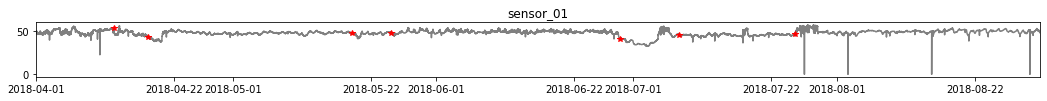

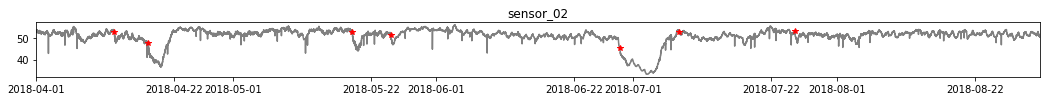

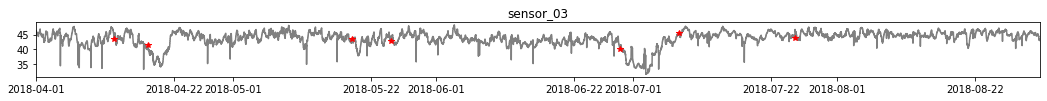

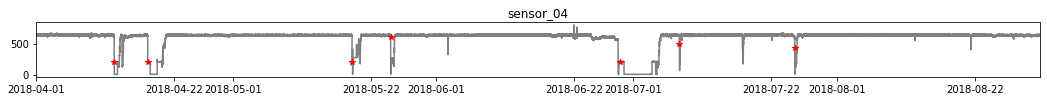

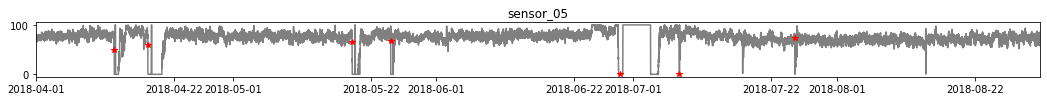

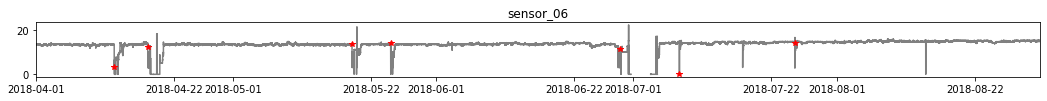

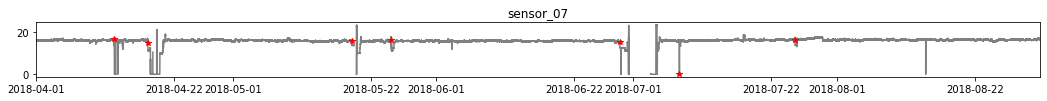

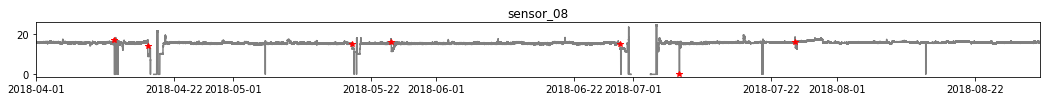

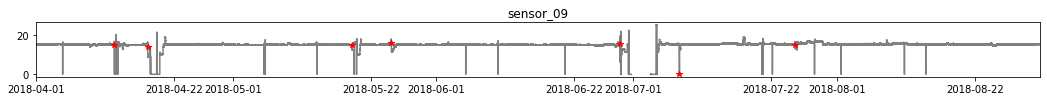

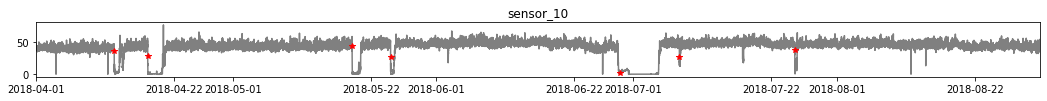

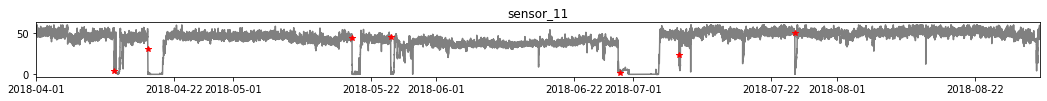

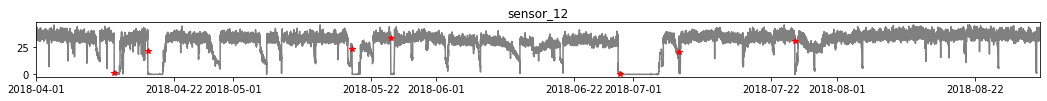

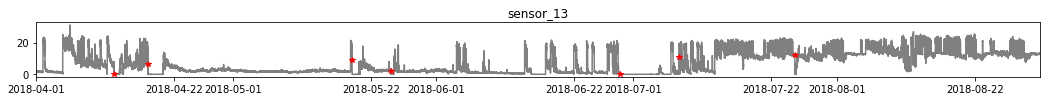

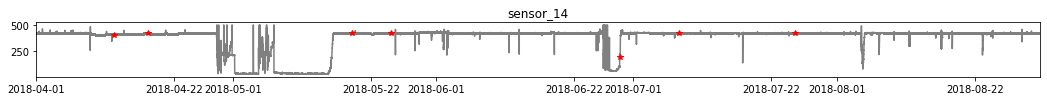

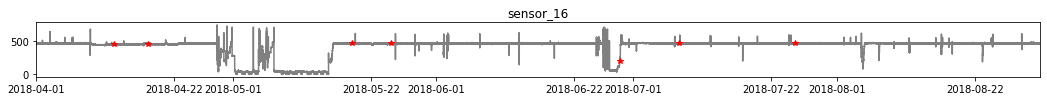

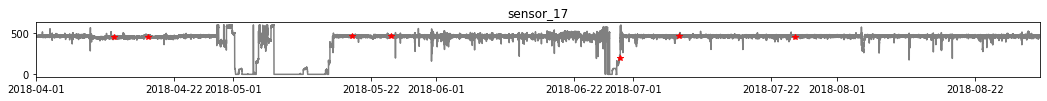

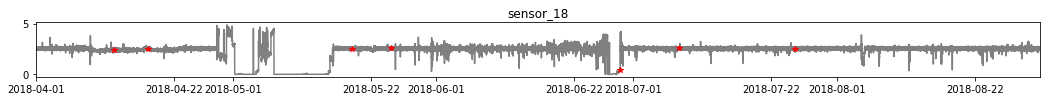

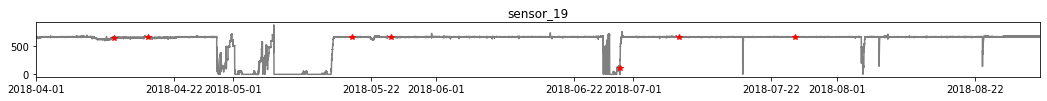

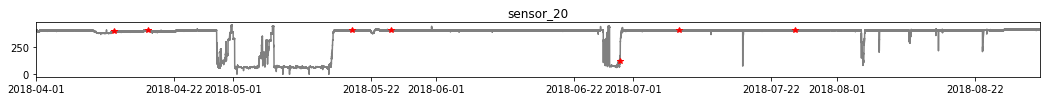

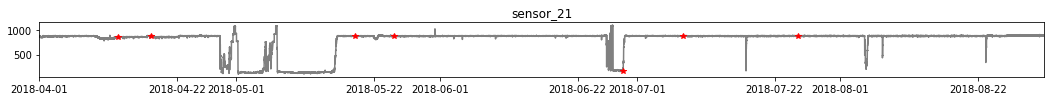

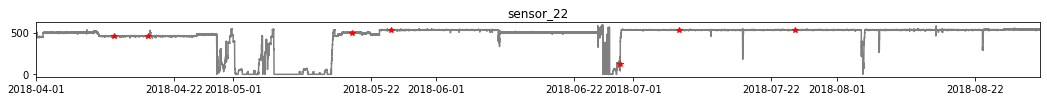

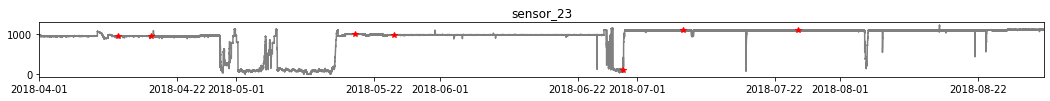

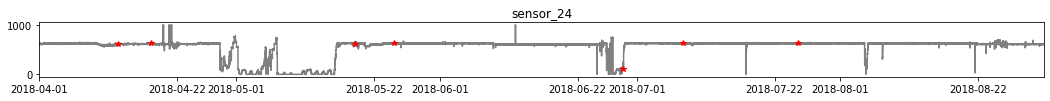

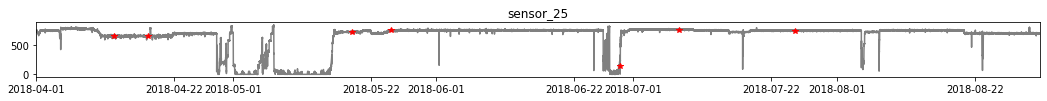

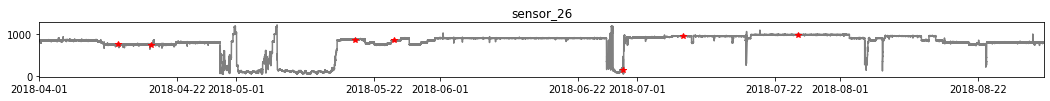

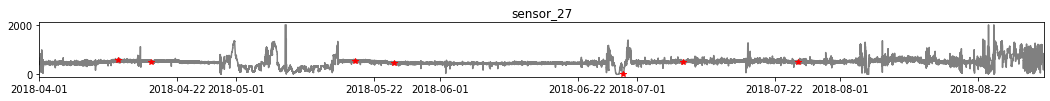

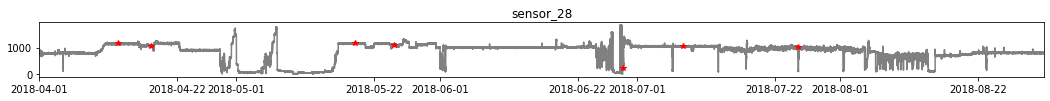

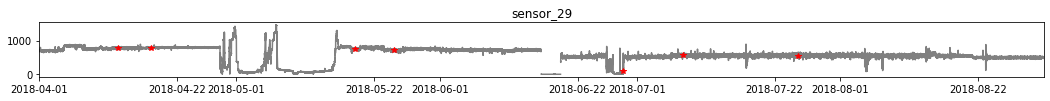

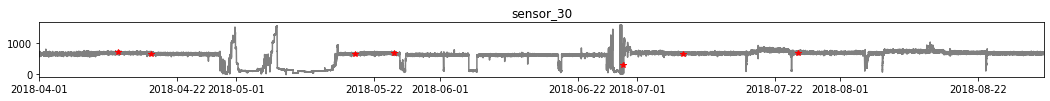

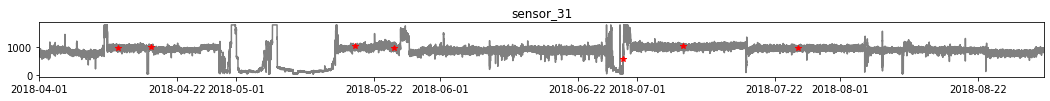

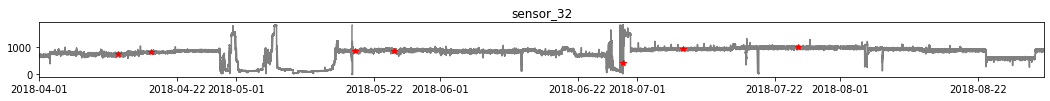

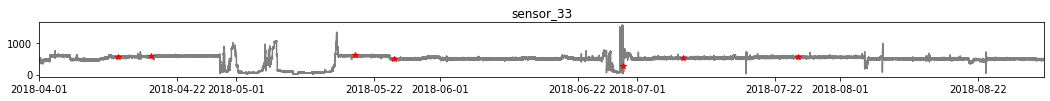

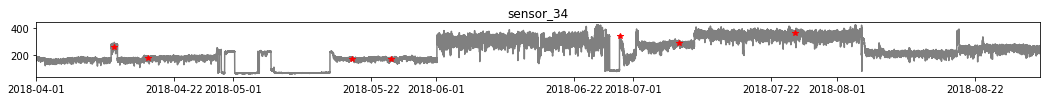

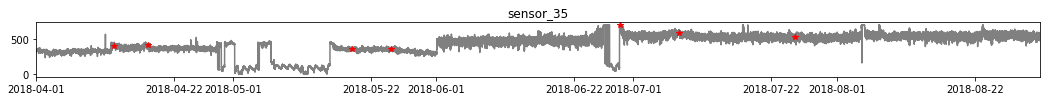

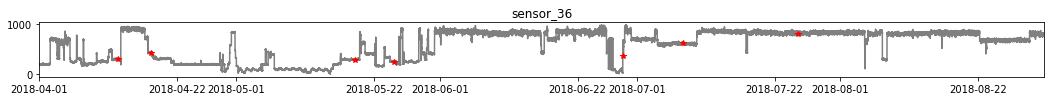

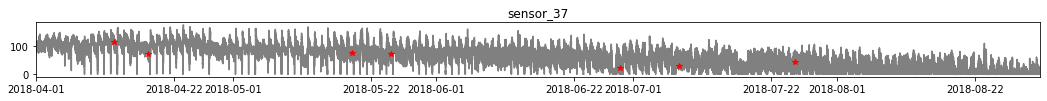

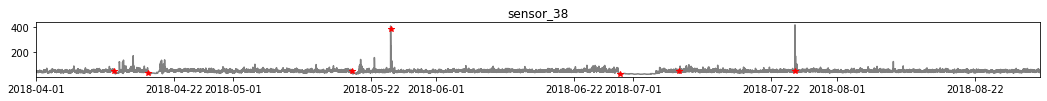

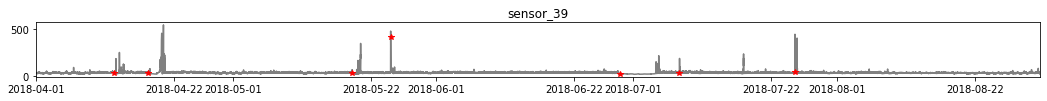

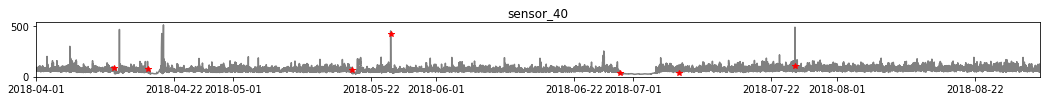

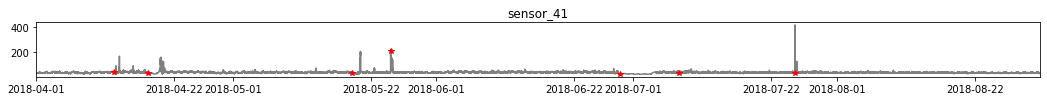

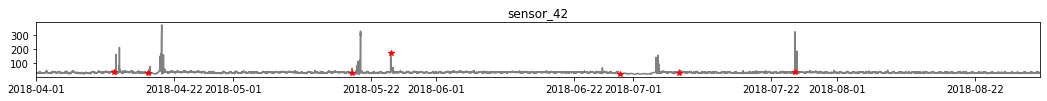

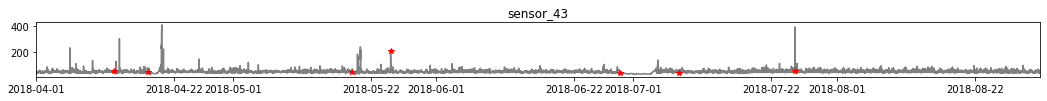

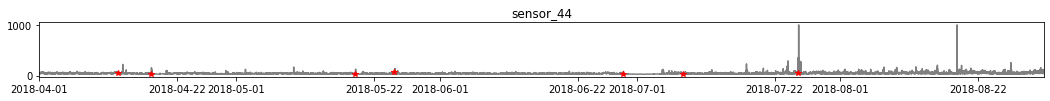

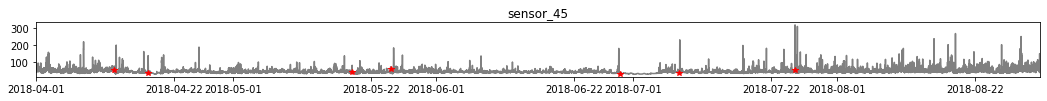

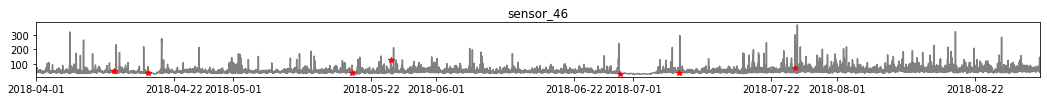

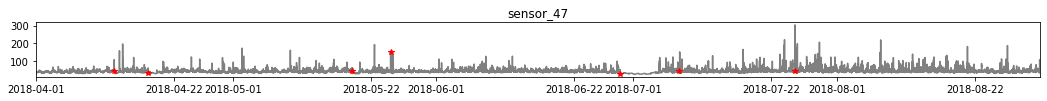

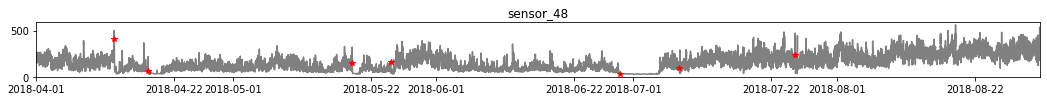

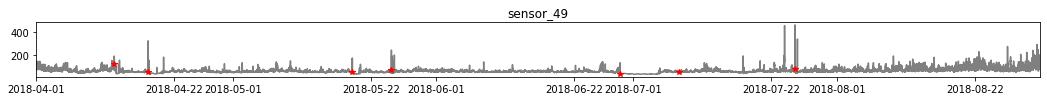

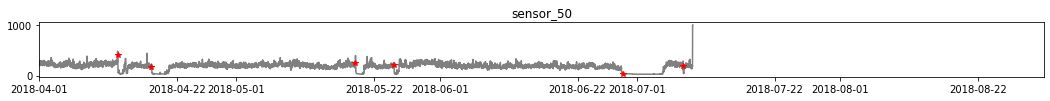

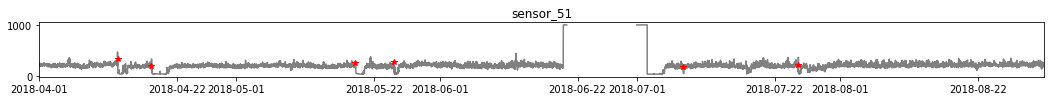

In [ ]:
def plot_sensor_each(df,Failure_times,sensor_name):
  plt.figure(figsize=(18,1))
  plt.plot(df.index,df[sensor_name], color='grey');
  plt.plot(df.loc[Failure_times].index,df.loc[Failure_times][sensor_name],linestyle='none',marker='*',color='red',markersize=6);
  plt.xlim([df.index[0],df.index[-1]])
  plt.title(sensor_name);

#let's check all the sensors
sensor_names=df.drop(['machine_status'],axis=1).columns
Failure_times=df[df['machine_status']==1].index
for i in range(10):
  for sensor_name in sensor_names[(i)*5+1:(i+1)*5+1]:
    plot_sensor_each(df,Failure_times,sensor_name);

Obervations:
* Sensors vary a lot in range. We need to re-adjust all sensor data separately so that the value of each column is in the same range (0 to 1).
* After the machine fails and during the machine recovery period, some sensors have null values. These missing values ​​are not important anyway. 
* Many sensors have very similar traces. We can do the correlation plot for each pair of the sensors. PCA can be used to reduce the dimention of the sensors. 
* Some sensors, such as sensor_00-05, show abnormal activity before the machine fails. These sensors are very useful if we want to predict machine failures in advance.
* Some sensors, such as sensor_51, did not show a clear relationship with the machine failure. However, we can not get a reliable conclusion from the eyes.

* The data of Sensor_50 was lost after the 6th failure of the machine; 
* Sensor_51 and sensor_50 are quite similar, and sensor_51 the 5th sensor data is lost. 

Conclusion:
* We need to rescale all the sensors in the same range (0-1).
* We can plot the heatmap of the correlations between each sensor pairs to view the relationship between the sensors.
* We need to use PCA to reduce the dimension of the sensors. 
* The time windows (for example 2h-5min) before the machine failure are very important.We need to visualize these pre_failure time windows.
* The recovery time window is not important to us. In addition, a large amount of sensor data will be lost during this time window.

Qestions to ask:
* Why are there so many similar sensors? For security reasons?
* If there is a failure, how long in advance does the engineer need to perform the operation? I assume that 5 minutes before the machine fails is the shortest time. 


In [ ]:
df.drop('sensor_50', axis=1, inplace=True)

### 3.3.2 Correlation between sensors

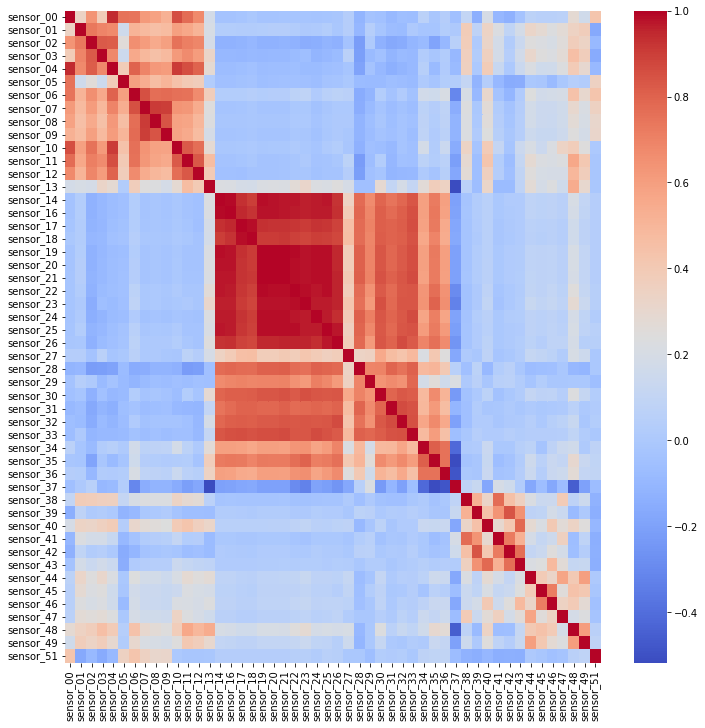

In [ ]:
# any relationship between the sensors?
sensor_names=df.drop(['machine_status'],axis=1).columns
plt.figure(figsize=(12,12))
corr = df[sensor_names].corr()
sns.heatmap(corr,cmap='coolwarm');

Observation:
* Obviously, there are many sensors with super high correlation, which is consistent with our naked eye observation from the sensor traces. 

### 3.3.3 Sensor traces in Pre-failure windows (4h-5min) 
To get an idea whether some sensors can be used to predict the machine failure in advance, I plot the sensor trace in a time window of 4h before the machine failure. 

In [ ]:
def plot_sensor_each_failure(Failure_times,sensor_name):
  plt.subplots(figsize=(18,5),nrows=7,ncols=1)
  for i,failure_time in enumerate(Failure_times):
    plt.subplot(7,1,i+1)
    start_time=failure_time-pd.Timedelta(seconds=60*60*4) # 240 mins before the failure time
    stop_time=failure_time+pd.Timedelta(seconds=60*30) # 30 mins after the failure time
    df_BeforeAfter_each_failure=df.loc[start_time:stop_time]
    plt.plot(df_BeforeAfter_each_failure.index,df_BeforeAfter_each_failure[sensor_name],c='grey');
    plt.plot(failure_time,df_BeforeAfter_each_failure[sensor_name].loc[failure_time],c='red',linestyle='none',marker='*',markersize=6);
    plt.xlim([start_time,stop_time])
  plt.title(sensor_name)    

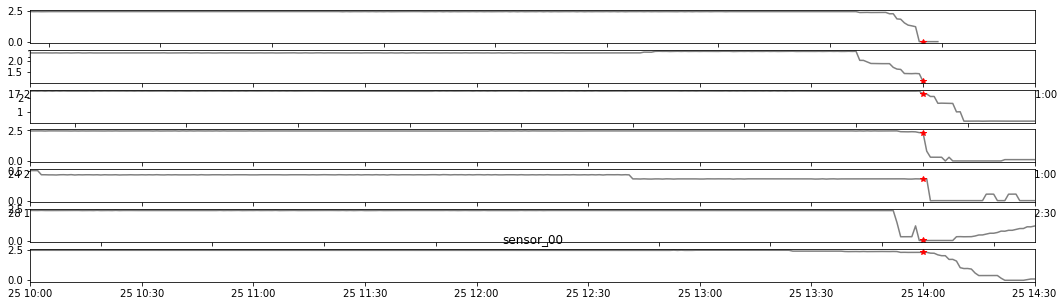

In [ ]:
# Let's check some sensors first to see if the sensors are abnormal before the machine fails
Failure_times=df[df['machine_status']==1].index
plot_sensor_each_failure(Failure_times,'sensor_00')

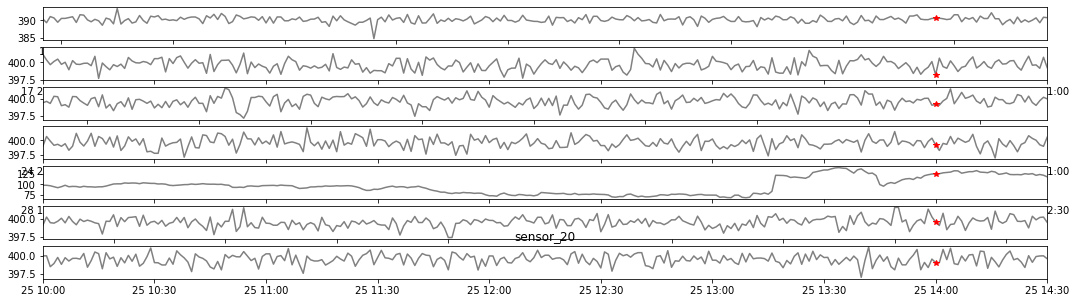

In [ ]:
Failure_times=df[df['machine_status']==1].index
plot_sensor_each_failure(Failure_times,'sensor_20')

Observation:
* Sensor_00 highly correlates with the machine failure and can be a good indicator.
* Sensor_20 did not show a clear relationship with the machine failure.


### 3.3.4 Interactive plots
It is difficult to see the detailed information of the sensor traces near the machine failure time from the above plots. I made interactive plots where you can zoom in/out to see the details of the sensor traces near each failure time. To avoid messing up this notebook, I made a separate notebook specifically for interactive plots. Please find it from [here](https://colab.research.google.com/drive/13OQ-4P4RxxE9bwDoBKa96tLCxBH9Ax6q#scrollTo=koxmQpduXHoT). 


## Conclusions:
* As analyzed above, many sensors show abnormal acitivies before the machine failure, which indicated that using these sensor data, ML models can predict the machine failure in advance. 

---

## Which ML model?
* I would define this problem is a <font color=yellow>'supervised time series classification'</font> problem;
* A common, but problematic solution to time series classification is to treat each time point as a separate feature and directly apply a standard learning algorithm (e.g. scikit-learn classifiers). In this approach, the algorithm ignores information contained in the time order of the data ([here](https://towardsdatascience.com/a-brief-introduction-to-time-series-classification-algorithms-7b4284d31b97)). I will not use this way for this project. 

* <font color=yellow>LSTMs</font>

> Deep neural networks have proved to be an effective solution for time series forecasting given their capacity to <font color=pink>automatically learn the temporal dependencies present in time series</font>. Moreover, their capacity to <font color=pink>adapt directly to the data without any prior assumptions</font> provides significant advantages when dealing with little information about the time series.  

> Paper: An Experimental Review on Deep Learning Architectures for Time Series Forecasting (2021). 
* This paper compares 7 deep neural networks for time series forcasting. They found that among the 7 models, <font color=pink>long short-term memory (LSTM) and convolutional networks (CNN) are the best alternatives, with LSTMs obtaining the most accurate forecasts.</font> CNNs achieve comparable performance with less variability of results under different parameter configurations, while also being more efficient.

> 7 deep neural architecures for time series forcasting:
* multilayer perceptron (MLP)
* Elman recurrent neural network ERNN, 
* <font color=pink>long-short term memory (LSTM)</font>
* <font color=pink>gated recurrent unit (GRU)</font>
* echo state network (ESN)
* <font color=pink>convolutional neural network (CNN)</font>
* temporal convolutional network (TCN).

Based on the above, I will use the LSTM model to predict machine failures.
---


# If you directly want to see the performance of the final model, please click [CaseStudy_Sensors_FinalModel.ipynb](https://colab.research.google.com/drive/10qhvQl4sPsCOy29hVh0XAWVQGMX5dFFs).


---




# 4. Data preparation

## What data?
Since the goal is to predict whether the machine fails <font color=yellow>in advance</font>, 
* the time windows that is <font color=yellow>2h-5min before the machine failure</font> are used as alarm windows;
* to avoid data imbalance, in this notebook, the time windows that are <font color=yellow>12h-4h before the machine failure</font> is used as normal windows.

## Data preparation
* Standardize the sensor data to a value between 0 and 1;
* Use PCA to reduce the dimention of the features;
* Add one 'alarm' column to label the 'alarm windows' (value=1, 4h-5min ahead of the machine failure; value=0, 12h-4h ahead of the machine failure;
* Generate data samples for LSTM.
Split the sequence into multiple samples, where each sample has a specified number of time steps, and the output is a single time step;
* Train, test split.


## 4.1 Manually select the interested sensors

The original idea was to calculate the correlation between every two sensor pairs and manually divide the sensors into several groups. Finally, I did not use this method to select sensors. One of the reasons is that grouping sensors requires domain knowledge of the sensors.

In [ ]:
# find high correlated sensor pairs
corr = df.corr().abs().unstack()
df_corr=pd.DataFrame(corr,columns=['corr_value'])
sensor_pairs=df_corr[df_corr.corr_value>0.9].index.tolist()
high_corr_pairs=[]
for sensor_pair in sensor_pairs:
  if sensor_pair[0] != sensor_pair[1]:
    high_corr_pairs.append(sensor_pair)

high_corr_pairs

In [ ]:
df_features=df.copy()
df_features['sensor_group1']=df_features[['sensor_00','sensor_04','sensor_10']].mean(axis=1)
df_features['sensor_group2']=df_features[['sensor_07','sensor_08','sensor_09']].mean(axis=1)
df_features['sensor_group3']=df_features.iloc[:,14:26].mean(axis=1)
columns_drop=[0,4,7,8,9,10,14,15,16,17,18,19,20,21,22,23,24,25]
df_features.drop(df_features.columns[columns_drop], axis=1, inplace=True)

## 4.2 PCA
* First, fill in na. There is no need to fill in na, because from the above analysis, we can see that the missing value occurs in the recovery period. However, if we want to use PCA to reduce the dimension of features, we need to fill in na.


> The Series Pandas object provides an interpolate() function to interpolate missing values, and there is a nice selection of simple and more complex interpolation functions. You may have domain knowledge to help choose how values are to be interpolated. Click [here](https://machinelearningmastery.com/resample-interpolate-time-series-data-python/#:~:text=The%20Series%20Pandas%20object%20provides,to%20use%20a%20linear%20interpolation.) for more details.





In [ ]:
# reload the data
df=pd.read_csv('/content/drive/MyDrive/CaseStudy_SensorData/pump_sensor.csv',index_col='timestamp',parse_dates=True)
df.drop(['Unnamed: 0',"sensor_15","sensor_50"],axis=1,inplace=True)
df.replace({'BROKEN': 1, 'NORMAL': 0,'RECOVERING':0.5}, inplace=True)

In [ ]:
# a linear interpolation 
df=df.interpolate(method='linear',limit_direction='backward',axis=0)
Df=df.copy() # for later use

* Second, standardize the sensor data in to a value between 0 and 1.


In [ ]:
from sklearn.preprocessing import MinMaxScaler

sensor_names=df.columns[:-1]
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(df[sensor_names])
df_scaled=scaler.transform(df[sensor_names])

In [ ]:
from sklearn.decomposition import PCA
pca=PCA(n_components=8).fit(df_scaled)
df_pca=pd.DataFrame(pca.transform(df_scaled))

pcs = ['pc'+str(i+1) for i in range(8)]
df_pca.columns = pcs
df_pca['machine_status']=df['machine_status'].values
df_pca.index=df.index

Df_pca=df_pca.copy() # for later use

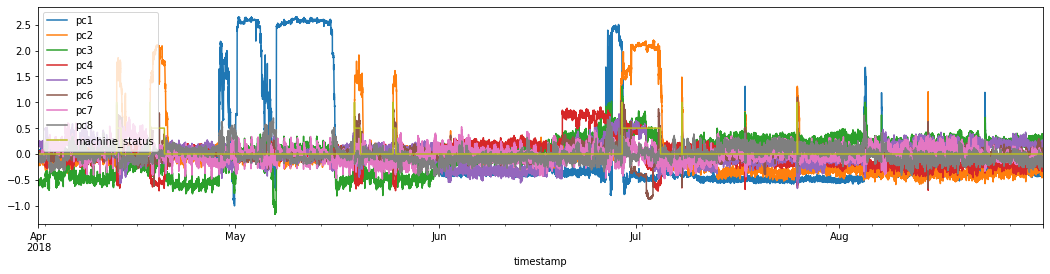

In [ ]:
df_pca.plot(figsize=(18,4));

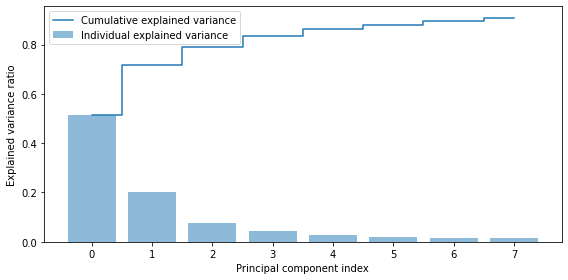

In [ ]:
# Determine explained variance using explained_variance_ration_ attribute
exp_var_pca = pca.explained_variance_ratio_
#
# Cumulative sum of eigenvalues; This will be used to create step plot
# for visualizing the variance explained by each principal component.
#
cum_sum_eigenvalues = np.cumsum(exp_var_pca)
#
# Create the visualization plot
#
plt.figure(figsize=(8,4))
plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [ ]:
df_pca.corr().style.background_gradient(cmap='coolwarm')

,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,machine_status
pc1,1.000000,-0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.000000,-0.097461
pc2,-0.000000,1.000000,-0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,0.894360
pc3,0.000000,-0.000000,1.000000,-0.000000,-0.000000,0.000000,-0.000000,-0.000000,0.136694
pc4,-0.000000,0.000000,-0.000000,1.000000,0.000000,-0.000000,0.000000,0.000000,-0.154999
pc5,0.000000,0.000000,-0.000000,0.000000,1.000000,-0.000000,0.000000,0.000000,0.075173
pc6,-0.000000,-0.000000,0.000000,-0.000000,-0.000000,1.000000,-0.000000,-0.000000,0.016028
pc7,0.000000,0.000000,-0.000000,0.000000,0.000000,-0.000000,1.000000,-0.000000,0.027129
pc8,-0.000000,0.000000,-0.000000,0.000000,0.000000,-0.000000,-0.000000,1.000000,0.007209
machine_status,-0.097461,0.894360,0.136694,-0.154999,0.075173,0.016028,0.027129,0.007209,1.000000


## 4.3 Add alarm column

In [ ]:
def add_alarm_column(df, Failure_times,timewindow_for_prediction):

  """
  Add one 'alarm' column to label the 'alarm windows'.
  value=2, 4h-5min ahead of the machine failure; 
  value=0, 12h-4h ahead of the machine failure;
  """
  df['alarm']=df['machine_status']
  for i,failure_time in enumerate(Failure_times):
    start_predic_time=failure_time-pd.Timedelta(seconds=60*timewindow_for_prediction[0]) #  mins before the failure time
    stop_predic_time=failure_time-pd.Timedelta(seconds=60*timewindow_for_prediction[1]) #  mins before the failure time
    df.loc[start_predic_time:stop_predic_time,'alarm']=2 # can not use 1, because 1 indicate the machine failure time
  return df

Failure_times=df_pca[df_pca['machine_status']==1].index
df=add_alarm_column(df_pca, Failure_times,(2*60,1)) # 2h-1min ahead of failure is the alarm windows


## 4.4 Generate data samples for LSTM

In [ ]:
def generate_seq_preFailure(df,Failure_times,features_columns,timewindow_for_use, window_len, stride):
  '''
  Generate data samples using the time windows ahead of each machine failure time;
  window_len: how many data points from each feature will be used to make one sample for the model. 
  stride: sliding window size
  '''
  X = np.empty((1,1,window_len*len(features_columns)), float)
  Y=np.empty((1), float)

  for i,failure_time in enumerate(Failure_times):
    windows_start=failure_time-pd.Timedelta(seconds=60*timewindow_for_use[0]) #  mins before the failure time
    windows_end=failure_time-pd.Timedelta(seconds=60*timewindow_for_use[1]) #  mins before the failure time

    df_prefailure_single_window_feature=df.loc[windows_start:windows_end,features_columns]
    df_prefailure_single_window_target=df.loc[windows_start:windows_end,'alarm']
    
    data=df_prefailure_single_window_feature.to_numpy().tolist()
    targets=df_prefailure_single_window_target.tolist()

    data_gen=tf.keras.preprocessing.sequence.TimeseriesGenerator(data, targets, window_len,stride=stride,sampling_rate=1,batch_size=1,shuffle=True)

    for i in range(len(data_gen)):
      x, y = data_gen[i]
      x=np.transpose(x).flatten()
      x=x.reshape((1,1,len(x)))
      X=np.append(X,x,axis=0)
      Y=np.append(Y,y/2,axis=0) # alarm windows are marked as 2, however, for the model, I will use 1 becasue of the sigmoid function. 
  return X,Y

In [ ]:
Failure_times=df_pca[df['machine_status']==1].index[1:] # I will use the first failure time as my test dataset
features_columns=df.columns.tolist()[:-2]
timewindow_for_use=(12*60,5) # windows of 12h-5min will be used. 
window_len=10 # 10 mins data for each feature
stride=1 # sliding window
X,Y=generate_seq_preFailure(df,Failure_times,features_columns,timewindow_for_use,window_len, stride)
X.shape, Y.shape

((4237, 1, 80), (4237,))

In [ ]:
np.unique(Y)

array([ 0.,  1., nan])

In [ ]:
# remove the sample with Y=nan
id_keep= np.where((Y == 0) | (Y ==1))
Y=Y[id_keep]
X=X[id_keep][:,:]

In [ ]:
# positive cases
print('Alarm samples:',np.sum(Y==1)/len(Y))
print('Normal state:',1-np.sum(Y==1)/len(Y))

Alarm samples: 0.17351274787535412
Normal state: 0.8264872521246459


## 4.5 Train, test split
In this notebook, I will use three dataset:
* training dataset
* validation dataset -- provide an unbiased evaluation of a model fit on the training dataset while tuning model hyperparameters. 
* test dataset -- provide an unbiased evaluation of a final model fit on the training dataset.
* More details can be found [here](https://towardsdatascience.com/train-validation-and-test-sets-72cb40cba9e7).

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=42)
X_train.shape,X_val.shape,y_train.shape, y_val.shape

# 5. LSTM Modeling

## 5.1 Build the stacked LSTM model

Hyperparameters:
* 4 layers of LSTM.
* 128, 128, 64, 64 units in each LSTM layer.
* Slope for Leaky ReLU is set at 0.2. Leaky ReLU is a type of activation function based on a ReLU, but it has a small slope for negative values instead of a flat slope. It allows a small gradient when the unit is not active.
* A dropout rate = 0.3 is set to avoid overfitting.

* Activation function of the output layer is set to'sigmoid' because of the binary classification problem.

Epoch 1/100
53/53 [==============================] - 9s 15ms/step - loss: 0.4689 - binary_accuracy: 0.8321
Epoch 2/100
53/53 [==============================] - 1s 16ms/step - loss: 0.3220 - binary_accuracy: 0.8737
Epoch 3/100
53/53 [==============================] - 1s 16ms/step - loss: 0.2423 - binary_accuracy: 0.9035
Epoch 4/100
53/53 [==============================] - 1s 17ms/step - loss: 0.2085 - binary_accuracy: 0.9147
Epoch 5/100
53/53 [==============================] - 1s 18ms/step - loss: 0.1728 - binary_accuracy: 0.9274
Epoch 6/100
53/53 [==============================] - 1s 17ms/step - loss: 0.1875 - binary_accuracy: 0.9233
Epoch 7/100
53/53 [==============================] - 1s 16ms/step - loss: 0.1489 - binary_accuracy: 0.9357
Epoch 8/100
53/53 [==============================] - 1s 17ms/step - loss: 0.1351 - binary_accuracy: 0.9430
Epoch 9/100
53/53 [==============================] - 1s 17ms/step - loss: 0.1206 - binary_accuracy: 0.9472
Epoch 10/100
53/53 [=================

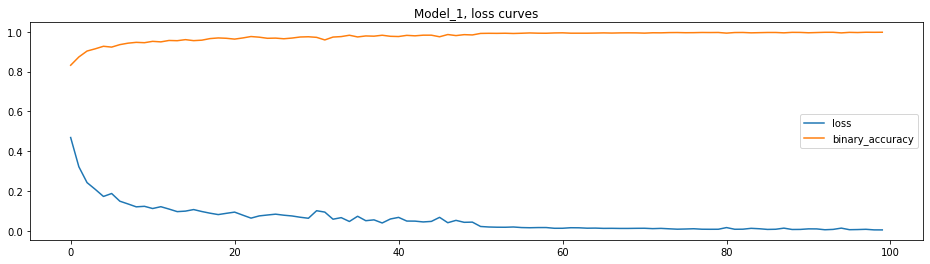

In [ ]:
# 4 LSTM layers, with 128, 128, 64,64 units in each layer
from numpy.random import seed
seed(42)

tf.random.set_seed(42)

model_1 = tf.keras.Sequential()
model_1.add(tf.keras.layers.LSTM(128,input_shape=(X_train.shape[1],X_train.shape[2]),return_sequences=True))
model_1.add(tf.keras.layers.LeakyReLU(alpha=0.2)) # 

model_1.add(tf.keras.layers.LSTM(128,return_sequences=True))
model_1.add(tf.keras.layers.LeakyReLU(alpha=0.2))
model_1.add(tf.keras.layers.Dropout(0.3))

model_1.add(tf.keras.layers.LSTM(64,return_sequences=True))
model_1.add(tf.keras.layers.LeakyReLU(alpha=0.2)) # 
model_1.add(tf.keras.layers.Dropout(0.3))

model_1.add(tf.keras.layers.LSTM(64,return_sequences=True))
model_1.add(tf.keras.layers.LeakyReLU(alpha=0.2))
model_1.add(tf.keras.layers.Dropout(0.3)) # to prevent overfiting

model_1.add(tf.keras.layers.Dense(1,activation='sigmoid'))

model_1.compile(loss='binary_crossentropy',
       optimizer=tf.keras.optimizers.Adam(lr=0.01), # tried 0.1, 0.01, 0.001, 0.01 gives the best results
       metrics=['binary_accuracy']
       )

# create a learning rate callback, reduce the lr during the training
def scheduler(epoch, lr):
  if epoch < 50:
    return lr
  else:
    return 0.001

lr_scheduler= tf.keras.callbacks.LearningRateScheduler(scheduler)

#model.summary()

history_1=model_1.fit(X_train, y_train, epochs=100, callbacks=[lr_scheduler],batch_size=64, verbose=1, shuffle=True)

# plot the loss (or training) curves
pd.DataFrame(history_1.history).iloc[:,:2].plot(figsize=(16,4));
plt.title('Model_1, loss curves');

## 5.2 Evaluate the model
### 5.2.1 Validation dataset

In [ ]:
def plot_confusion_matrix(y_test,y_test_preds,flag_model):
  # creat confusion matrics
  cm=confusion_matrix(y_test,tf.round(y_test_preds))
  cm_norm=cm.astype('float')/cm.sum(axis=1)[:,np.newaxis] # normalize the confusion matrics
  n_classes=cm.shape[0]

  fig,ax=plt.subplots(figsize=(5,5))
  cax=ax.matshow(cm, cmap=plt.cm.Blues)
  fig.colorbar(cax)

  # create classes
  classes=False
  if classes:
    labels=classes
  else:
    labels=np.arange(cm.shape[0])

  # label the axes
  ax.set(title=flag_model,
      xlabel='Predicted label',
      ylabel='True label',
      xticks=np.arange(n_classes),
      yticks=np.arange(n_classes),
      xticklabels=labels,
      yticklabels=labels)

  # set x-axis labels to bottom
  ax.xaxis.set_label_position('bottom')
  ax.xaxis.tick_bottom()

  # adjust label size
  ax.yaxis.label.set_size(20)
  ax.title.set_size(20)
  ax.xaxis.label.set_size(20)

  # set threshold for different colors
  threshold=(cm.max()+cm.min())/2.

  # plot the text on each cell
  for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
    plt.text(j,i,f"{cm[i,j]}({cm_norm[i,j]*100:.1f}%)",
        horizontalalignment='center',
        color='white' if cm[i,j]>threshold else 'black',
        size=15)
    
from sklearn.metrics import confusion_matrix
import itertools

27/27 [==============================] - 2s 5ms/step - loss: 0.0410 - binary_accuracy: 0.9917
Model loss on the validation set: 0.0410
Model accuracy on the validation set: 99.17%
Model recall on the validation set: 0.9706
Model precison on the validation set: 0.9958


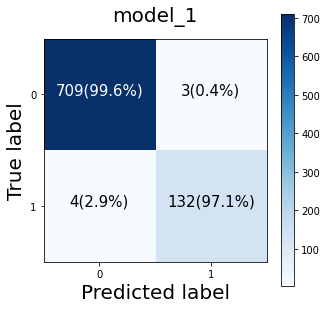

In [ ]:
# evaluation1: loss and accuracy
loss,accuracy=model_1.evaluate(X_val,y_val)
print(f'Model loss on the validation set: {loss:.4f}')
print(f'Model accuracy on the validation set: {(accuracy*100):.2f}%')

# evaluation2: recall
y_val_preds_1=model_1.predict(X_val).flatten()
y_val_preds_1=tf.round(y_val_preds_1)
cm=confusion_matrix(y_val,tf.round(y_val_preds_1))
recall=(cm[1,1])/(cm[1,1]+cm[1,0])
precision=(cm[0,0])/(cm[0,1]+cm[0,0])
print(f'Model recall on the validation set: {recall:.4f}') 
print(f'Model precison on the validation set: {precision:.4f}') 

# evaluation3: confusion matrix
plot_confusion_matrix(y_val,y_val_preds_1,'model_1')

Works well on Validation data

## 5.3 Test dataset
### 5.3.1 Generate test dataset

In [ ]:
# Generate test dataset
def generate_seq_single_preFailure(df,failure_time,features_columns,timewindow_for_use,window_len,stride):
  '''
  Generate the test data set using one machine failure time.
  '''
  
  X = np.empty((1,1,window_len*len(features_columns)), float)
  Y=np.empty((1), float)

  windows_start=failure_time-pd.Timedelta(seconds=60*timewindow_for_use[0]) #  mins before the failure time
  windows_end=failure_time-pd.Timedelta(seconds=60*timewindow_for_use[1]) #  mins before the failure time

  df_prefailure_single_window_feature=df.loc[windows_start:windows_end,features_columns]
  df_prefailure_single_window_target=df.loc[windows_start:windows_end,'alarm']
    
  data=df_prefailure_single_window_feature.to_numpy().tolist()
  targets=df_prefailure_single_window_target.tolist()

  data_gen=tf.keras.preprocessing.sequence.TimeseriesGenerator(data, targets, window_len,stride=stride,sampling_rate=1,batch_size=1,shuffle=False) # for ploting, do not shuffle the data

  for i in range(len(data_gen)):
    x, y = data_gen[i]
    x=np.transpose(x).flatten()
    x=x.reshape((1,1,len(x)))
    X=np.append(X,x,axis=0)
    Y=np.append(Y,y/2,axis=0)

  return X,Y


In [ ]:

failure_time=df[df['machine_status']==1].index[0] 
features_columns=df.columns.tolist()[:-2]
timewindow_for_use=(12*60,5) # 6h-5min
window_len=10
stride=1 
X_test,Y_test=generate_seq_single_preFailure(df,failure_time,features_columns,timewindow_for_use,window_len,stride)

# select
id_keep= np.where((Y_test == 0) | (Y_test ==1))
Y_test=Y_test[id_keep]
X_test=X_test[id_keep][:,:]
X_test.shape, Y_test.shape

((706, 1, 80), (706,))

### 5.3.2 Evaluate the test dataset

23/23 [==============================] - 0s 4ms/step - loss: 1.6776 - binary_accuracy: 0.8399
Model loss on the test set: 1.6776
Model accuracy on the test set: 83.99%
Model recall on the test set: 0.0259
Model precison on the test set: 1.0000


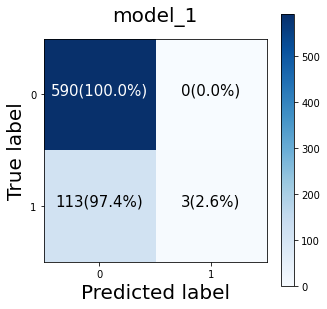

In [ ]:
# evaluation1: loss and accuracy
loss,accuracy=model_1.evaluate(X_test,Y_test)
print(f'Model loss on the test set: {loss:.4f}')
print(f'Model accuracy on the test set: {(accuracy*100):.2f}%')

# evaluation2: recall
y_test_preds_1=model_1.predict(X_test).flatten()
y_test_preds_1=y_test_preds_1.flatten()
y_test_preds_1=tf.round(y_test_preds_1)
cm=confusion_matrix(Y_test,tf.round(y_test_preds_1))
recall=(cm[1,1])/(cm[1,1]+cm[1,0])
precision=(cm[0,0])/(cm[0,1]+cm[0,0])
print(f'Model recall on the test set: {recall:.4f}') 
print(f'Model precison on the test set: {precision:.4f}') 

# evaluation3: confusion matrix
plot_confusion_matrix(Y_test,y_test_preds_1,'model_1')

Even I set the ramdom seed, the model gives different results everytime I run it! How to fix it?

Model_1 performed very bad on detecting the alarm states.
Next step:
* Increase the percentage of the alarm samples;
* Model overfiting, increase the dropout rate;
* To have more samples to train the model, I will not use validation dataset;
Anyway, becasue of the validation data set are quite similar to training data, it gives high performance of the model. 


## 5.4 Model_2


### 5.4.1 Label the 'alarm' and 'no alarm' data points
Data points 1h ahead of the machine failure is labeled as 'alarm' status.

In [ ]:
df_pca=Df_pca.copy()
Failure_times=df_pca[df_pca['machine_status']==1].index
df_pca=add_alarm_column(df_pca, Failure_times,(4*60,1)) # 4h-1min ahead of failure is the alarm windows
df=df_pca[['pc1','pc2','pc3','pc4','machine_status','alarm']]


### 5.4.2 Gernerate 'alarm' and 'no alarm' samples


In [ ]:
def generate_seq_preFailure2(df,Failure_times,features_columns,timewindow_for_use, window_len, stride):
  '''
  Generate data samples using the time windows ahead of each machine failure time;
  window_len: how many data points from each feature will be used to make one sample for the model. 
  stride: sliding window size
  '''
  X = np.empty((1,1,window_len*len(features_columns)), float)
  Y=np.empty((1), float)

  for i,failure_time in enumerate(Failure_times):
    windows_start=failure_time-pd.Timedelta(seconds=60*timewindow_for_use[0]) #  mins before the failure time
    windows_end=failure_time-pd.Timedelta(seconds=60*timewindow_for_use[1]) #  mins before the failure time

    df_prefailure_single_window_feature=df.loc[windows_start:windows_end,features_columns]
    df_prefailure_single_window_target=df.loc[windows_start:windows_end,'alarm']
    
    data=df_prefailure_single_window_feature.to_numpy().tolist()
    targets=df_prefailure_single_window_target.tolist()

    data_gen=tf.keras.preprocessing.sequence.TimeseriesGenerator(data, targets, window_len,stride=stride,sampling_rate=1,batch_size=1,shuffle=True)

    for i in range(len(data_gen)):
      x, y = data_gen[i]
      x=np.transpose(x).flatten()
      x=x.reshape((1,1,len(x)))
      X=np.append(X,x,axis=0)
      Y=np.append(Y,y/2,axis=0) # alarm windows are marked as 2, however, for the model, I will use 1 becasue of the sigmoid function. 

    # for alarm windown, no stride=1
    windows_start=failure_time-pd.Timedelta(seconds=60*timewindow_for_use[2]) #  mins before the failure time
    windows_end=failure_time-pd.Timedelta(seconds=60*timewindow_for_use[3]) #  mins before the failure time

    df_prefailure_single_window_feature=df.loc[windows_start:windows_end,features_columns]
    df_prefailure_single_window_target=df.loc[windows_start:windows_end,'alarm']
    
    data=df_prefailure_single_window_feature.to_numpy().tolist()
    targets=df_prefailure_single_window_target.tolist()

    data_gen=tf.keras.preprocessing.sequence.TimeseriesGenerator(data, targets, window_len,stride=1,sampling_rate=1,batch_size=1,shuffle=True)

    for i in range(len(data_gen)):
      x, y = data_gen[i]
      x=np.transpose(x).flatten()
      x=x.reshape((1,1,len(x)))
      X=np.append(X,x,axis=0)
      Y=np.append(Y,y/2,axis=0) # alarm windows are marked as 2, however, for the model, I will use 1 becasue of the sigmoid function. 


  return X,Y

In [ ]:
Failure_times=df[df['machine_status']==1].index[1:] # I will use the first failure time as my test dataset, 2-7 as my test dataset
features_columns=df.columns.tolist()[:-2]
timewindow_for_use=(14*60,4*60,4*60, 5) # windows of 14h-2h ahead of failure time is used to generate 'no alarm' samples; 1h-5min ahead is used to generate 'alarm' samples.
window_len=6 # sequence length is 6 points (6 min). 
stride=window_len # sliding window for 'no alarm' samples, no overlap of the data points of the 'no alarm' samples
X,Y=generate_seq_preFailure2(df,Failure_times,features_columns,timewindow_for_use,window_len, stride)

# remove the sample with Y=nan
id_keep= np.where((Y == 0) | (Y ==1))
Y=Y[id_keep]
X=X[id_keep][:,:]

print(X.shape, Y.shape)

# positive cases
print('Alarm samples:',np.sum(Y==1)/len(Y)) # 

(1980, 1, 24) (1980,)
Alarm samples: 0.6974747474747475


### 5.4.3 Build model_2
To get reproducible-results, I set the random seed.  
https://machinelearningmastery.com/reproducible-results-neural-networks-keras/

Epoch 1/100
31/31 - 7s - loss: 0.6845 - binary_accuracy: 0.6924
Epoch 2/100
31/31 - 0s - loss: 0.6368 - binary_accuracy: 0.6975
Epoch 3/100
31/31 - 0s - loss: 0.5713 - binary_accuracy: 0.7141
Epoch 4/100
31/31 - 0s - loss: 0.5357 - binary_accuracy: 0.7424
Epoch 5/100
31/31 - 0s - loss: 0.5143 - binary_accuracy: 0.7434
Epoch 6/100
31/31 - 0s - loss: 0.4943 - binary_accuracy: 0.7465
Epoch 7/100
31/31 - 0s - loss: 0.4686 - binary_accuracy: 0.7636
Epoch 8/100
31/31 - 0s - loss: 0.4588 - binary_accuracy: 0.7758
Epoch 9/100
31/31 - 0s - loss: 0.4355 - binary_accuracy: 0.7929
Epoch 10/100
31/31 - 0s - loss: 0.4327 - binary_accuracy: 0.8111
Epoch 11/100
31/31 - 0s - loss: 0.4209 - binary_accuracy: 0.8227
Epoch 12/100
31/31 - 0s - loss: 0.4097 - binary_accuracy: 0.8263
Epoch 13/100
31/31 - 0s - loss: 0.4004 - binary_accuracy: 0.8222
Epoch 14/100
31/31 - 0s - loss: 0.4017 - binary_accuracy: 0.8227
Epoch 15/100
31/31 - 0s - loss: 0.3879 - binary_accuracy: 0.8338
Epoch 16/100
31/31 - 0s - loss: 0.

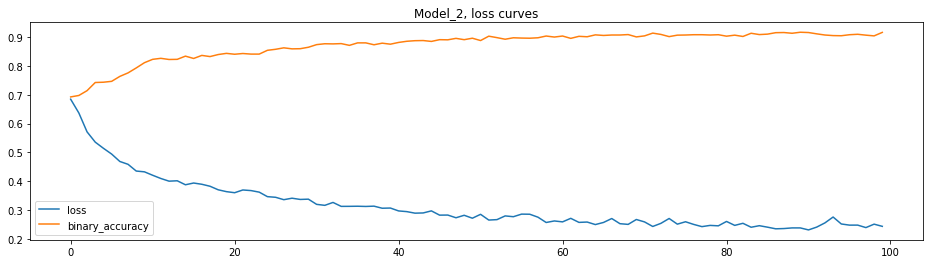

In [ ]:
# 4 LSTM layers, with 128, 128, 64,64 units in each layer
from numpy.random import seed
seed(2)

tf.random.set_seed(1)

model_2 = tf.keras.Sequential()

model_2.add(tf.keras.layers.LSTM(128,input_shape=(X.shape[1],X.shape[2]),return_sequences=True))
model_2.add(tf.keras.layers.LeakyReLU(alpha=0.2)) # 

model_2.add(tf.keras.layers.LSTM(64,return_sequences=True))
model_2.add(tf.keras.layers.LeakyReLU(alpha=0.2))
model_2.add(tf.keras.layers.Dropout(0.5))

model_2.add(tf.keras.layers.LSTM(64,return_sequences=True))
model_2.add(tf.keras.layers.LeakyReLU(alpha=0.2)) # 
model_2.add(tf.keras.layers.Dropout(0.5))

model_2.add(tf.keras.layers.LSTM(64,return_sequences=True))
model_2.add(tf.keras.layers.LeakyReLU(alpha=0.2))
model_2.add(tf.keras.layers.Dropout(0.5)) # to prevent overfiting

model_2.add(tf.keras.layers.Dense(1,activation='sigmoid'))

model_2.compile(loss='binary_crossentropy',
       optimizer=tf.keras.optimizers.Adam(lr=0.001), # tried 0.1, 0.01, 0.001, 0.01 gives the best results
       metrics=['binary_accuracy']
       )

# create a learning rate callback, reduce the lr during the training
def scheduler(epoch, lr):
  if epoch < 50:
    return lr
  else:
    return 0.001

lr_scheduler= tf.keras.callbacks.LearningRateScheduler(scheduler)

#model.summary()

history_2=model_2.fit(X, Y, epochs=100, callbacks=[lr_scheduler],batch_size=64, verbose=2, shuffle=True)

# plot the loss (or training) curves
pd.DataFrame(history_2.history).iloc[:,:2].plot(figsize=(16,4));
plt.title('Model_2, loss curves');

### 5.4.4 Evaluatin on test data set

In [ ]:
# Generate test samples
failure_time=df[df['machine_status']==1].index[0]
print('failure time:',failure_time)
features_columns=df.columns.tolist()[:-2]
timewindow_for_use=(60*60,5) # 60h-5min
window_len=6
stride=1 # For testing samples, both 'alarm' and 'no alarm' samples are generated with overlap, because in real production, we want to generate a real time prediction, don't want to have gaps. 
X_test,Y_test=generate_seq_single_preFailure(df,failure_time,features_columns,timewindow_for_use,window_len,stride)

print('number of positive samples', np.sum(Y_test==1))
# select
id_keep= np.where((Y_test == 0) | (Y_test ==1))
Y_test=Y_test[id_keep]
X_test=X_test[id_keep][:,:]
X_test.shape, Y_test.shape

failure time: 2018-04-12 21:55:00
number of positive samples 236


((3590, 1, 24), (3590,))

113/113 [==============================] - 2s 3ms/step - loss: 0.9889 - binary_accuracy: 0.8613
Model loss on the test set: 0.9889
Model accuracy on the test set: 86.13%
Model recall on the test set: 0.0254
Model precison on the test set: 0.9201


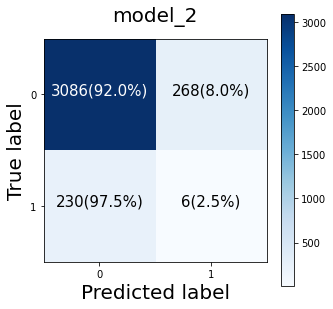

In [ ]:
# evaluation1: loss and accuracy
loss,accuracy=model_2.evaluate(X_test,Y_test)
print(f'Model loss on the test set: {loss:.4f}')
print(f'Model accuracy on the test set: {(accuracy*100):.2f}%')

# evaluation2: recall
y_test_preds_2=model_2.predict(X_test).flatten()
y_test_preds_2=y_test_preds_2.flatten()
y_test_preds_2=tf.round(y_test_preds_2)
cm=confusion_matrix(Y_test,tf.round(y_test_preds_2))
recall=(cm[1,1])/(cm[1,1]+cm[1,0])
precision=(cm[0,0])/(cm[0,1]+cm[0,0])
print(f'Model recall on the test set: {recall:.4f}') 
print(f'Model precison on the test set: {precision:.4f}') 

# evaluation3: confusion matrix
plot_confusion_matrix(Y_test,y_test_preds_2,'model_2')

* Model_2 still not performed well on detecting the 'alarm' states;
* Increase the percentage of the "alarm" samples to let the model learn the alarm state pattern!

## Before we do the above step, let's first see where the predicted alarms are. 

failure time: 2018-04-12 21:55:00


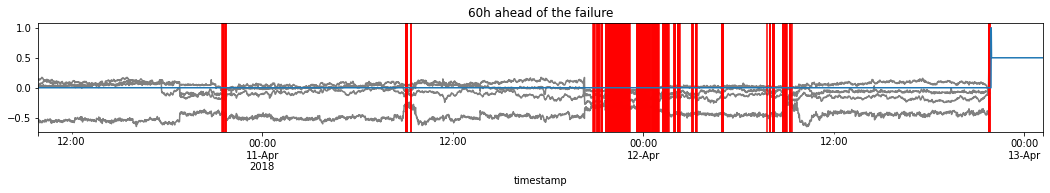

In [ ]:
print('failure time:',failure_time)
windows_start=failure_time-pd.Timedelta(seconds=60*timewindow_for_use[0])
windows_end=failure_time-pd.Timedelta(seconds=60*timewindow_for_use[1])
df_preFailure=df.loc[windows_start:windows_end,:]

y_test_preds_2=model_2.predict(X_test).flatten()
y_test_preds_2=tf.round(y_test_preds_2)
df_preFailure['alarm']=np.append(np.zeros(window_len),(y_test_preds_2))

df_preFailure[['pc1','pc2','pc3','pc4']].plot(c="grey",figsize=(18,2),legend=None)
df_preFailure[df_preFailure['alarm']==1].index.to_list()

# vertical lines
for xc in df_preFailure[df_preFailure['alarm']==1].index.to_list():
  plt.axvline(x=xc,c='red')

df_pca['machine_status'].plot()
plt.xlim([windows_start,windows_end+pd.Timedelta(seconds=60*200)])

plt.title("60h ahead of the failure")
plt.show()


* Eventhough the confusion matrix showed not good performance of model_2 on detecting the 'alarm' state, however, it predicted the alarm state relatively near the failure time (about 12h ahead). 

So, the next step I will try is:
1.   Label the alarm status much longer ahead of the failure, 12h;
2.   Use longer time steps for the model, 20 steps (20min);


## 5.5 Model_3 

### 5.5.1 Label the 'alarm' and 'no alarm' data points
Data points 12h ahead of the machine failure is labeled as 'alarm' status.

In [ ]:
df_pca=Df_pca.copy()
Failure_times=df_pca[df_pca['machine_status']==1].index
df_pca=add_alarm_column(df_pca, Failure_times,(12*60,1)) # 12h ahead of failure is the alarm points
df=df_pca[['pc1','pc2','pc3','pc4','machine_status','alarm']]

### 5.5.2 Gernerate 'alarm' and 'no alarm' samples

In [ ]:
Failure_times=df[df['machine_status']==1].index[1:] # I will use the first failure time as my test dataset, 2-7 as my test dataset
features_columns=df.columns.tolist()[:-2]
timewindow_for_use=(96*60,12*60,12*60, 5) # windows of 96h-2h ahead of failure time is used to generate 'no alarm' samples; 12h-5min ahead is used to generate 'alarm' samples.
window_len=20 # sequence length is 6 points (6 min). 
stride=5 # sliding window for 'no alarm' samples, no overlap of the data points of the 'no alarm' samples
X,Y=generate_seq_preFailure2(df,Failure_times,features_columns,timewindow_for_use,window_len, stride)

# remove the sample with Y=nan
id_keep= np.where((Y == 0) | (Y ==1))
Y=Y[id_keep]
X=X[id_keep][:,:]

print(X.shape, Y.shape)

# positive cases
print('Alarm samples:',np.sum(Y==1)/len(Y)) # 

(9976, 1, 80) (9976,)
Alarm samples: 0.41870489174017644


### 5.5.3 Build model_3

Epoch 1/50
156/156 - 36s - loss: 0.6422 - binary_accuracy: 0.6105
Epoch 2/50
156/156 - 2s - loss: 0.4995 - binary_accuracy: 0.7488
Epoch 3/50
156/156 - 2s - loss: 0.4304 - binary_accuracy: 0.7937
Epoch 4/50
156/156 - 2s - loss: 0.3863 - binary_accuracy: 0.8184
Epoch 5/50
156/156 - 2s - loss: 0.3551 - binary_accuracy: 0.8313
Epoch 6/50
156/156 - 2s - loss: 0.3277 - binary_accuracy: 0.8426
Epoch 7/50
156/156 - 2s - loss: 0.3060 - binary_accuracy: 0.8597
Epoch 8/50
156/156 - 2s - loss: 0.2955 - binary_accuracy: 0.8669
Epoch 9/50
156/156 - 2s - loss: 0.2844 - binary_accuracy: 0.8783
Epoch 10/50
156/156 - 2s - loss: 0.2714 - binary_accuracy: 0.8831
Epoch 11/50
156/156 - 2s - loss: 0.2599 - binary_accuracy: 0.8903
Epoch 12/50
156/156 - 2s - loss: 0.2527 - binary_accuracy: 0.8934
Epoch 13/50
156/156 - 2s - loss: 0.2490 - binary_accuracy: 0.8946
Epoch 14/50
156/156 - 2s - loss: 0.2322 - binary_accuracy: 0.9012
Epoch 15/50
156/156 - 2s - loss: 0.2391 - binary_accuracy: 0.8978
Epoch 16/50
156/15

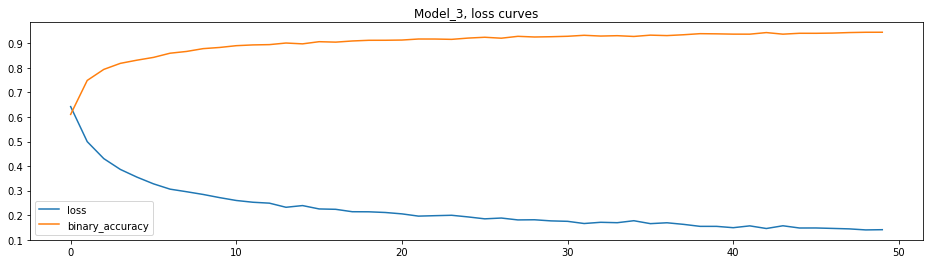

In [ ]:
# 4 LSTM layers, with 128, 128, 64,64 units in each layer
from numpy.random import seed
# seed(2)

tf.random.set_seed(1)

model_3 = tf.keras.Sequential()

model_3.add(tf.keras.layers.LSTM(128,input_shape=(X.shape[1],X.shape[2]),return_sequences=True))
model_3.add(tf.keras.layers.LeakyReLU(alpha=0.2)) # 

model_3.add(tf.keras.layers.LSTM(64,return_sequences=True))
model_3.add(tf.keras.layers.LeakyReLU(alpha=0.2))
model_3.add(tf.keras.layers.Dropout(0.5)) # keep the dropout the same as model_2, as model_2 not over fitting 

model_3.add(tf.keras.layers.LSTM(64,return_sequences=True))
model_3.add(tf.keras.layers.LeakyReLU(alpha=0.2)) # 
model_3.add(tf.keras.layers.Dropout(0.5))

model_3.add(tf.keras.layers.LSTM(64,return_sequences=False))
model_3.add(tf.keras.layers.LeakyReLU(alpha=0.2))
model_3.add(tf.keras.layers.Dropout(0.5)) # to prevent overfiting

model_3.add(tf.keras.layers.Dense(1,activation='sigmoid'))

model_3.compile(loss='binary_crossentropy',
       optimizer=tf.keras.optimizers.Adam(lr=0.001), # tried 0.1, 0.01, 0.001, 0.01 gives the best results
       metrics=['binary_accuracy']
       )

# create a learning rate callback, reduce the lr during the training
def scheduler(epoch, lr):
  if epoch < 25:
    return lr
  else:
    return 0.001

lr_scheduler= tf.keras.callbacks.LearningRateScheduler(scheduler)

#model.summary()

history_3=model_3.fit(X, Y, epochs=50, callbacks=[lr_scheduler],batch_size=64, verbose=2, shuffle=True)

# plot the loss (or training) curves
pd.DataFrame(history_3.history).iloc[:,:2].plot(figsize=(16,4));
plt.title('Model_3, loss curves');

### 5.5.4 Evaluatin on test data set

In [ ]:
# Generate test samples
failure_time=df[df['machine_status']==1].index[0]
print('failure time:',failure_time)
features_columns=df.columns.tolist()[:-2]
timewindow_for_use=(60*60,5) # 60h-5min
window_len=20
stride=1 
X_test,Y_test=generate_seq_single_preFailure(df,failure_time,features_columns,timewindow_for_use,window_len,stride)

print('number of positive samples', np.sum(Y_test==1))
# select
id_keep= np.where((Y_test == 0) | (Y_test ==1))
Y_test=Y_test[id_keep]
X_test=X_test[id_keep][:,:]
X_test.shape, Y_test.shape

failure time: 2018-04-12 21:55:00
number of positive samples 716


((3576, 1, 80), (3576,))

112/112 [==============================] - 2s 3ms/step - loss: 0.4976 - binary_accuracy: 0.8786
Model loss on the test set: 0.4976
Model accuracy on the test set: 87.86%
Model recall on the test set: 0.3939
Model precison on the test set: 1.0000


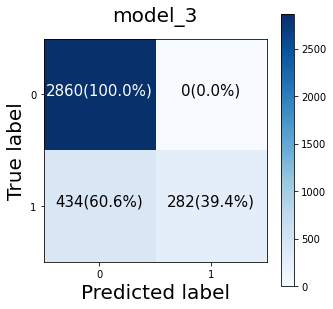

In [ ]:
# evaluation1: loss and accuracy
loss,accuracy=model_3.evaluate(X_test,Y_test)
print(f'Model loss on the test set: {loss:.4f}')
print(f'Model accuracy on the test set: {(accuracy*100):.2f}%')

# evaluation2: recall
y_test_preds_3=model_3.predict(X_test).flatten()
y_test_preds_3=y_test_preds_3.flatten()
y_test_preds_3=tf.round(y_test_preds_3)
cm=confusion_matrix(Y_test,tf.round(y_test_preds_3))
recall=(cm[1,1])/(cm[1,1]+cm[1,0])
precision=(cm[0,0])/(cm[0,1]+cm[0,0])
print(f'Model recall on the test set: {recall:.4f}') 
print(f'Model precison on the test set: {precision:.4f}') 

# evaluation3: confusion matrix
plot_confusion_matrix(Y_test,y_test_preds_3,'model_3')

* Model_3 performed much better on detecting the 'alarm' status; In real production, it is good.
* Let's check where are these predicted 'alarm' satuses. 

failure time: 2018-04-12 21:55:00


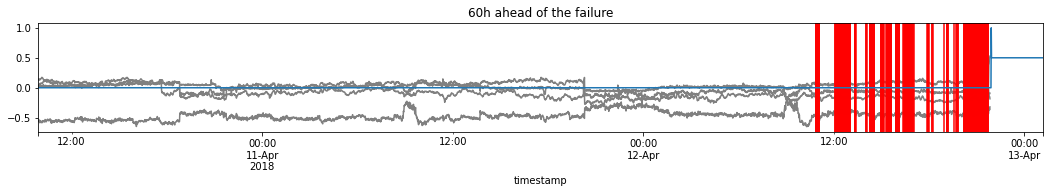

In [ ]:
print('failure time:',failure_time)
windows_start=failure_time-pd.Timedelta(seconds=60*timewindow_for_use[0])
windows_end=failure_time-pd.Timedelta(seconds=60*timewindow_for_use[1])
df_preFailure=df.loc[windows_start:windows_end,:]

y_test_preds_3=model_3.predict(X_test).flatten()
y_test_preds_3=tf.round(y_test_preds_3)
df_preFailure['alarm']=np.append(np.zeros(window_len),(y_test_preds_3))

df_preFailure[['pc1','pc2','pc3','pc4']].plot(c="grey",figsize=(18,2),legend=None)
df_preFailure[df_preFailure['alarm']==1].index.to_list()

# vertical lines
for xc in df_preFailure[df_preFailure['alarm']==1].index.to_list():
  plt.axvline(x=xc,c='red')

df_pca['machine_status'].plot()
plt.xlim([windows_start,windows_end+pd.Timedelta(seconds=60*200)])

plt.title("60h ahead of the failure")
plt.show()

I think model_3 performed quite well on the testing data! It will start to make alarms 12h ahead of the machine failure.

## 5.6 How it will look like in real production?

In [ ]:
from matplotlib.animation import FuncAnimation
from matplotlib import rc 
rc('animation', html='html5') # equivalent to rcParams['animation.html'] = 'html5'

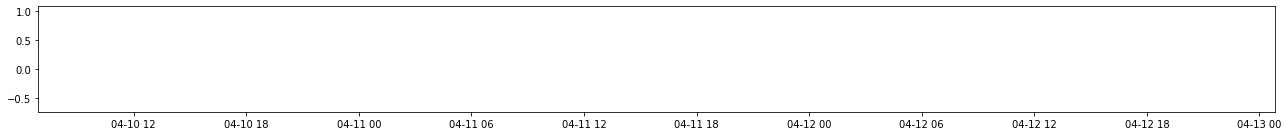

In [ ]:
def animate(i):
  x=df_preFailure.index[:i*100]
  y1=df_preFailure["pc1"][:i*100]
  y2=df_preFailure["pc2"][:i*100]
  y3=df_preFailure["pc3"][:i*100]
  y4=df_preFailure["pc4"][:i*100]
  machine_status=df_preFailure['machine_status'][:i*100]
  alarm=df_preFailure['alarm'][:i*100]
  
  plt.cla()
  plt.plot(x,y1,c="grey")
  plt.plot(x,y2,c="grey")
  plt.plot(x,y3,c="grey")
  plt.plot(x,y4,c="grey")
  plt.plot(x,alarm,label='alarm',c="red")
  plt.tight_layout()

plt.figure(figsize=(18,2))
ani=FuncAnimation(plt.gcf(),animate,interval=1000,frames=40, repeat=True)
ani

# 6. Conclusions


The results confirm that the LSTM model is suitable for early detection of machine failures (12h-5min before failure). Based on the performance of the model on the test data, I suggest that in real production, if the model issues an alarm, then the engineer can wait to see if more alarms will come. If no more alarms appear, then the engineers do not need to do anything. But if more alarms come, then the engineers need to check whether there is a problem.

However, considering that I first used PCA to reduce the dimension of all sensor input, even if one of the sensors failed, the model would not work. Given that many sensors are highly correlated, one of the possibilities for optimizing the model may be
* group sensors into several groups based on the correalation between each other and the domain knowledge of the sensors. 
* select one sensor from each group to train the model. 

By doing so, in real production, if one sensor used in the model breaks down, we can choose a second one from its group to do the prediction.

On the other hand, in this notebook, the model is evaluated on test data, which participate in standerlize and pca of the preprocessing. This is not right. I corrected this error in the final version of the model. Find it [here](https://colab.research.google.com/drive/10qhvQl4sPsCOy29hVh0XAWVQGMX5dFFs).


# 7. References
* Jason Brownlee, [How to Get Started with Deep Learning for Time Series Forecasting (7-Day Mini-Course)](https://machinelearningmastery.com/how-to-get-started-with-deep-learning-for-time-series-forecasting-7-day-mini-course/). 
* Jason Brownlee, [How to Develop LSTM Models for Time Series Forecasting](https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/). 
* Alexandra Amidon, [A Brief Survey of Time Series Classification Algorithms](https://towardsdatascience.com/a-brief-introduction-to-time-series-classification-algorithms-7b4284d31b97).
* Pedro Lara-Benítez, [An Experimental Review on Deep Learning Architectures for Time Series Forecasting](https://arxiv.org/abs/2103.12057).
* Tarang Shah, [About Train, Validation and Test Sets in Machine Learning](https://towardsdatascience.com/train-validation-and-test-sets-72cb40cba9e7).
* Jason Brownlee, [How to Get Reproducible Results with Keras](https://machinelearningmastery.com/reproducible-results-neural-networks-keras/).


# Thank you very much for checking the code, and suggestions are welcome!